<a href="https://colab.research.google.com/github/somilasthana/deeplearningtutorial/blob/master/GAN_MINIST_Details.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
"""
GANs, or Generative Adversarial Networks, are a framework for estimating generative models. 
Two models are trained simultaneously by an adversarial process: a Generator and a Discriminator.

Generative is responsible for generating data (say, images), and 

a Discriminator, which is responsible for estimating the probability that an image was drawn 
from the training data (the image is real), or was produced by the Generator (the image is fake). 

During training, the Generator becomes progressively better at generating images, 
until the Discriminator is no longer able to distinguish real images from fake.



"""

In [1]:
# Install imgeio in order to generate an animated gif showing the image generating process
!pip install imageio

In [0]:
import tensorflow as tf
tf.enable_eager_execution()

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time

from IPython import display

In [8]:
(train_images, train_label), (_,_) = tf.keras.datasets.mnist.load_data()
print(train_images.shape)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5)/127.5

(60000, 28, 28)


In [6]:
train_images.shape

(60000, 28, 28, 1)

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Reshape((7, 7, 256)),
    tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2DTranspose(64, (5, 5),  strides=(2, 2), padding='same', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2DTranspose(1,  (5, 5),  strides=(2, 2), padding='same', use_bias=False, activation='tanh')  
])

In [0]:
discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64,  (5, 5), strides= (2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(128, (5, 5), strides= (2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1)
])

In [0]:
"""The generator loss is a sigmoid cross entropy loss of generated images and an array of ones"""
def generator_loss(generated_output):
  return tf.losses.sigmoid_cross_entropy(tf.ones_like(generated_output), generated_output)

In [0]:
"""The discriminator loss takes two inputs real image and generated image.
   real_loss is calculated with sigmoid cross entropy of real image with an array of ones
   generated_loss is calculated with signmoid cross entropy of generated images and an array of zeros

"""

def discriminator_loss(real_output, generated_output):
  
  real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones_like(real_output), logits=real_output)
  generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.zeros_like(generated_output), logits=generated_output)
  
  total_loss = real_loss + generated_loss
  
  return total_loss

In [0]:
generator_optimizer = tf.train.AdamOptimizer(1e-4)
discriminator_optimizer = tf.train.AdamOptimizer(1e-4)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

In [0]:
#Setup GAN for Training

EPOCHS=50
noise_dim=100
num_examples_to_generate=16

random_vector_for_generation = tf.random_normal(
    [
        num_examples_to_generate, noise_dim
    ]
)

In [0]:
def train_step(images):
  noise = tf.random_normal([BATCH_SIZE, noise_dim])
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    
    generated_images = generator(noise, training=True)
    
    """
    calculate the generator and the discriminator loss. Then, we calculate the gradients of 
    loss with respect to both the generator and the discriminator variables.
    """
    
    real_output = discriminator(images, training=True)
    generated_output = discriminator(generated_images, training=True)
    
    gen_loss = generator_loss(generated_output)
    disc_loss = discriminator_loss(real_output, generated_output)
    
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
  
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)
  
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))

In [0]:
train_step = tf.contrib.eager.defun(train_step)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  
  predictions=model(test_input, training=False)
  fig = plt.figure(figsize=(4,4))
  
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
        
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    
    for images in dataset:
      train_step(images)
      
    display.clear_output(wait=True)
    generate_and_save_images(
        generator,
        epoch+1,
        random_vector_for_generation
    )
    
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
      
    print ('Time taken for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
  display.clear_output(wait=True)
  generate_and_save_images(
      generator,
      epochs,
      random_vector_for_generation
  )

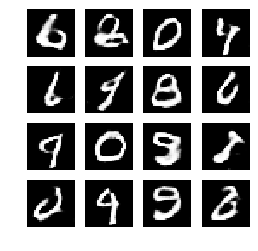

CPU times: user 2min 9s, sys: 40.1 s, total: 2min 49s
Wall time: 9min 40s


In [46]:
# Train
%%time
train(train_dataset, EPOCHS)

In [47]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [0]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

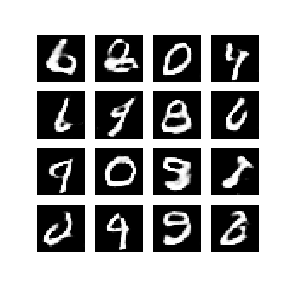

In [50]:
display_image(EPOCHS)

In [51]:
with imageio.get_writer('dcgan.gif', mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
    
# this is a hack to display the gif inside the notebook
os.system('cp dcgan.gif dcgan.gif.png')

0

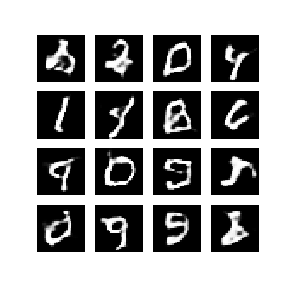

In [52]:
display.Image(filename="dcgan.gif.png")